In [1]:
import os
from os.path import join
import pickle
import json
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten, Activation
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import config
import dnnlib
import dnnlib.tflib as tflib
from encoder.generator_model import Generator
from utils import Shower

Using TensorFlow backend.
/home1/xiewenbin/anaconda3/envs/tf_1.15/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home1/xiewenbin/anaconda3/envs/tf_1.15/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home1/xiewenbin/anaconda3/envs/tf_1.15/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

/home1/xiewenbin/anaconda3/envs/tf_1.15/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home1/xiewenbin/anaconda3/envs/tf_1.15/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home1/xiewenbin/anaconda3/envs/tf_1.15/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home1/xie

In [2]:
# config
batch_size = 1
dlatent_path = './data'

image_ids = ['67138', '67139', '68245']

In [3]:
def load_dlatent(image_id):
    dl_path = join(dlatent_path, image_id + '.npy')
    dlatent = np.load(dl_path)
    dlatent = dlatent.reshape(-1, 18, 512)
    return dlatent

In [4]:
tflib.init_tf()
with open(config.model_url, 'rb') as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size);



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
with open(config.analysis_data_path, 'rb') as f:
    _, dlatent_data, labels_data = pickle.load(f)
labels_data[0]

{'faceId': 'b6807d9a-0ab5-4595-9037-c69c656c5c38',
 'faceRectangle': {'top': 322, 'left': 223, 'width': 584, 'height': 584},
 'faceLandmarks': {'pupilLeft': {'x': 386.0, 'y': 480.7},
  'pupilRight': {'x': 641.7, 'y': 481.1},
  'noseTip': {'x': 518.0, 'y': 648.1},
  'mouthLeft': {'x': 388.9, 'y': 748.0},
  'mouthRight': {'x': 645.1, 'y': 741.8},
  'eyebrowLeftOuter': {'x': 304.3, 'y': 441.0},
  'eyebrowLeftInner': {'x': 466.8, 'y': 442.9},
  'eyeLeftOuter': {'x': 345.4, 'y': 485.3},
  'eyeLeftTop': {'x': 385.2, 'y': 464.8},
  'eyeLeftBottom': {'x': 386.5, 'y': 497.1},
  'eyeLeftInner': {'x': 424.6, 'y': 487.6},
  'eyebrowRightInner': {'x': 572.8, 'y': 448.0},
  'eyebrowRightOuter': {'x': 738.0, 'y': 445.0},
  'eyeRightInner': {'x': 603.8, 'y': 485.0},
  'eyeRightTop': {'x': 646.0, 'y': 466.2},
  'eyeRightBottom': {'x': 644.9, 'y': 496.9},
  'eyeRightOuter': {'x': 686.7, 'y': 485.3},
  'noseRootLeft': {'x': 475.1, 'y': 493.3},
  'noseRootRight': {'x': 547.5, 'y': 493.9},
  'noseLeftAlarT

In [6]:
x_data = dlatent_data.reshape((-1, 18 * 512))

# gender

In [49]:
y_gender = np.array([x['faceAttributes']['gender'] == 'male' for x in labels_data])

In [51]:
model = Sequential()
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

model.fit(x_data, y_gender, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 4s 221us/step - loss: 0.2621 - accuracy: 0.8920 - val_loss: 0.2598 - val_accuracy: 0.8956
Epoch 2/100
16245/16245 [==============================] - 3s 197us/step - loss: 0.2328 - accuracy: 0.9046 - val_loss: 0.2488 - val_accuracy: 0.9067
Epoch 3/100
16245/16245 [==============================] - 3s 182us/step - loss: 0.2283 - accuracy: 0.9074 - val_loss: 0.2649 - val_accuracy: 0.8904
Epoch 4/100
16245/16245 [==============================] - 3s 161us/step - loss: 0.2279 - accuracy: 0.9082 - val_loss: 0.2545 - val_accuracy: 0.8944
Epoch 5/100
16245/16245 [==============================] - 3s 165us/step - loss: 0.2258 - accuracy: 0.9094 - val_loss: 0.2448 - val_accuracy: 0.8998
Epoch 6/100
16245/16245 [==============================] - 3s 200us/step - loss: 0.2279 - accuracy: 0.9082 - val_loss: 0.2525 - val_accuracy: 0.9020
Epoch 7/100
16245/16245 [==============================] 

In [52]:
gender_direction = model.layers[0].get_weights()[0]
gender_direction = gender_direction.reshape(18, 512)
np.save('./data/gender_direction', gender_direction)

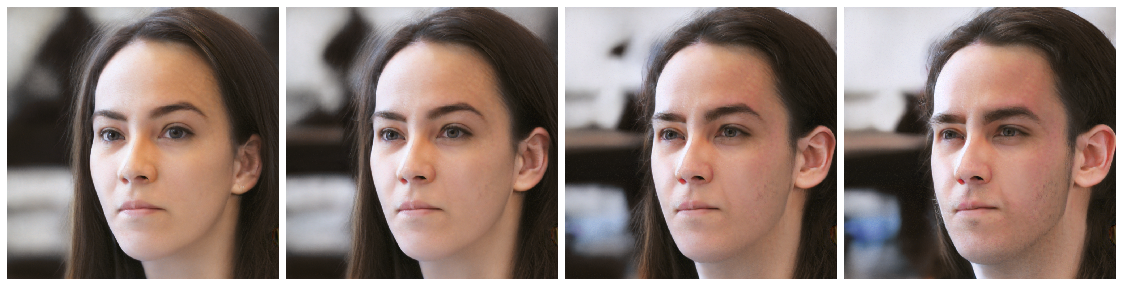

In [53]:
dlatent = load_dlatent(image_ids[0])
n = 4
shower = Shower(col=n)
plt.figure(figsize=(5 * n, 5))
for i in (0, 1, 2, 2.5):
    w = i
    new_dlatent = dlatent + w * gender_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show('gender')

# Age

In [23]:
y_age = np.array([x['faceAttributes']['age'] for x in labels_data])
len(y_age)

20307

In [65]:
model = Sequential()
model.add(Dense(1, activation='relu'))
model.compile('adam', 'mse', metrics=['mse'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

In [66]:
model.fit(x_data, y_age, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 4s 220us/step - loss: 214.6025 - mse: 214.6027 - val_loss: 117.2780 - val_mse: 117.2780
Epoch 2/100
16245/16245 [==============================] - 3s 181us/step - loss: 111.4725 - mse: 111.4725 - val_loss: 104.9792 - val_mse: 104.9792
Epoch 3/100
16245/16245 [==============================] - 3s 161us/step - loss: 102.8071 - mse: 102.8071 - val_loss: 99.6490 - val_mse: 99.6490
Epoch 4/100
16245/16245 [==============================] - 2s 134us/step - loss: 98.6418 - mse: 98.6418 - val_loss: 97.3947 - val_mse: 97.3947
Epoch 5/100
16245/16245 [==============================] - 3s 161us/step - loss: 96.1303 - mse: 96.1304 - val_loss: 95.2261 - val_mse: 95.2261
Epoch 6/100
16245/16245 [==============================] - 3s 157us/step - loss: 94.6814 - mse: 94.6813 - val_loss: 94.8817 - val_mse: 94.8817
Epoch 7/100
16245/16245 [==============================] - 2s 127us/step - loss: 93

In [67]:
age_direction = model.layers[0].get_weights()[0]
age_direction = age_direction.reshape(18, 512)
np.save('./data/age_direction', age_direction)

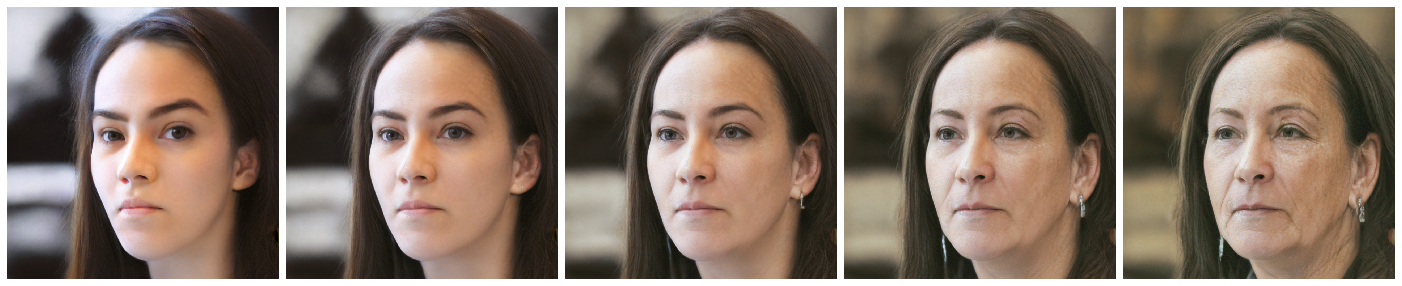

In [32]:
dlatent = load_dlatent(image_ids[0])
n = 5
shower = Shower(col=n)
plt.figure(figsize=(5 * n, 5))
for i in (-0.5, 0, 0.5, 1, 1.5):
    w = i
    new_dlatent = dlatent + w * age_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

# lipmakeup

In [33]:
y_lip_makeup = np.array([x['faceAttributes']['makeup']['lipMakeup'] for x in labels_data])

In [55]:
model = Sequential()
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

model.fit(x_data, y_lip_makeup, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 4s 224us/step - loss: 0.4829 - accuracy: 0.7776 - val_loss: 0.4742 - val_accuracy: 0.7883
Epoch 2/100
16245/16245 [==============================] - 3s 157us/step - loss: 0.4654 - accuracy: 0.7887 - val_loss: 0.4778 - val_accuracy: 0.7841
Epoch 3/100
16245/16245 [==============================] - 3s 190us/step - loss: 0.4633 - accuracy: 0.7898 - val_loss: 0.4822 - val_accuracy: 0.7770
Epoch 4/100
16245/16245 [==============================] - 3s 176us/step - loss: 0.4642 - accuracy: 0.7886 - val_loss: 0.4742 - val_accuracy: 0.7991
Epoch 5/100
16245/16245 [==============================] - 3s 157us/step - loss: 0.4623 - accuracy: 0.7876 - val_loss: 0.4838 - val_accuracy: 0.7895
Epoch 6/100
16245/16245 [==============================] - 3s 180us/step - loss: 0.4620 - accuracy: 0.7932 - val_loss: 0.4789 - val_accuracy: 0.7935
Epoch 00006: early stopping


In [56]:
lip_direction = model.layers[0].get_weights()[0]
lip_direction = lip_direction.reshape(18, 512)
np.save('./data/lip_direction', lip_direction)

In [57]:
lip_direction.min(), lip_direction.max()

(-0.12407979, 0.088023275)

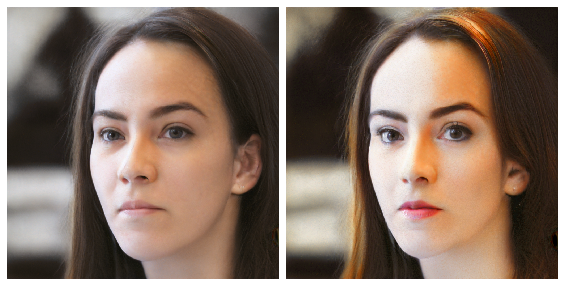

In [58]:
dlatent = load_dlatent(image_ids[0])
n = 2
shower = Shower(col=n)
plt.figure(figsize=(5 * n, 5))
for i in (0, 5):
    w = i
    new_dlatent = dlatent + w * lip_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

# eyeMakeup

In [39]:
y_eye_makeup = np.array([x['faceAttributes']['makeup']['eyeMakeup'] for x in labels_data])

In [43]:
model = Sequential()
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

model.fit(x_data, y_eye_makeup, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 4s 221us/step - loss: 0.4641 - accuracy: 0.7886 - val_loss: 0.4597 - val_accuracy: 0.7932
Epoch 2/100
16245/16245 [==============================] - 3s 188us/step - loss: 0.4448 - accuracy: 0.8012 - val_loss: 0.4635 - val_accuracy: 0.7873
Epoch 3/100
16245/16245 [==============================] - 3s 200us/step - loss: 0.4403 - accuracy: 0.8014 - val_loss: 0.4550 - val_accuracy: 0.7979
Epoch 4/100
16245/16245 [==============================] - 3s 173us/step - loss: 0.4398 - accuracy: 0.8012 - val_loss: 0.4471 - val_accuracy: 0.7986
Epoch 5/100
16245/16245 [==============================] - 3s 196us/step - loss: 0.4412 - accuracy: 0.8020 - val_loss: 0.4624 - val_accuracy: 0.7942
Epoch 6/100
16245/16245 [==============================] - 3s 164us/step - loss: 0.4431 - accuracy: 0.8013 - val_loss: 0.4692 - val_accuracy: 0.7836
Epoch 7/100
16245/16245 [==============================] 

In [44]:
eye_direction = model.layers[0].get_weights()[0]
eye_direction = eye_direction.reshape(18, 512)

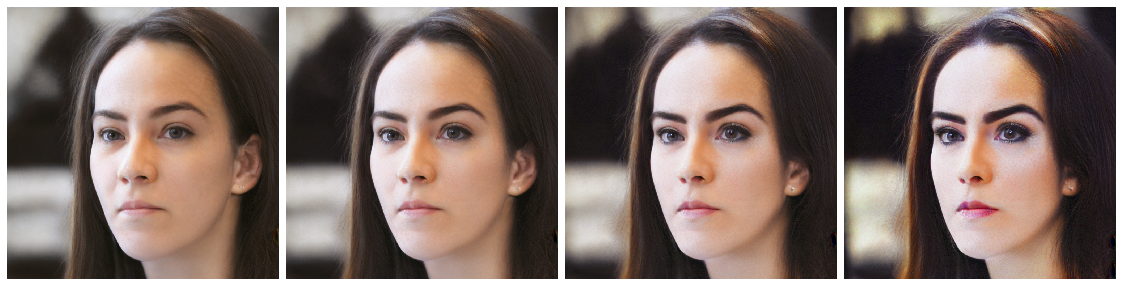

In [59]:
dlatent = load_dlatent(image_ids[0])
n = 4
shower = Shower(col=n)
plt.figure(figsize=(5 * n, 5))
for i in (0, 2, 4, 6):
    w = i
    new_dlatent = dlatent + w * eye_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

# makeup

In [60]:
y_makeup = np.array([(x['faceAttributes']['makeup']['eyeMakeup'] or x['faceAttributes']['makeup']['eyeMakeup']) for x in labels_data])

In [61]:
y_makeup.sum(), (~y_makeup).sum()

(9748, 10559)

In [68]:
model = Sequential()
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

model.fit(x_data, y_makeup, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 3s 173us/step - loss: 0.4658 - accuracy: 0.7884 - val_loss: 0.4637 - val_accuracy: 0.7878
Epoch 2/100
16245/16245 [==============================] - 3s 173us/step - loss: 0.4451 - accuracy: 0.7994 - val_loss: 0.4848 - val_accuracy: 0.7846
Epoch 3/100
16245/16245 [==============================] - 2s 150us/step - loss: 0.4398 - accuracy: 0.8018 - val_loss: 0.4689 - val_accuracy: 0.7843
Epoch 4/100
16245/16245 [==============================] - 3s 169us/step - loss: 0.4403 - accuracy: 0.8033 - val_loss: 0.4716 - val_accuracy: 0.7890
Epoch 5/100
16245/16245 [==============================] - 3s 154us/step - loss: 0.4383 - accuracy: 0.8041 - val_loss: 0.4724 - val_accuracy: 0.7866
Epoch 6/100
16245/16245 [==============================] - 2s 147us/step - loss: 0.4424 - accuracy: 0.8007 - val_loss: 0.4630 - val_accuracy: 0.7917
Epoch 7/100
16245/16245 [==============================] 

In [69]:
makeup_direction = model.layers[0].get_weights()[0]
makeup_direction = makeup_direction.reshape(18, 512)
np.save('./data/makeup_direction', makeup_direction)

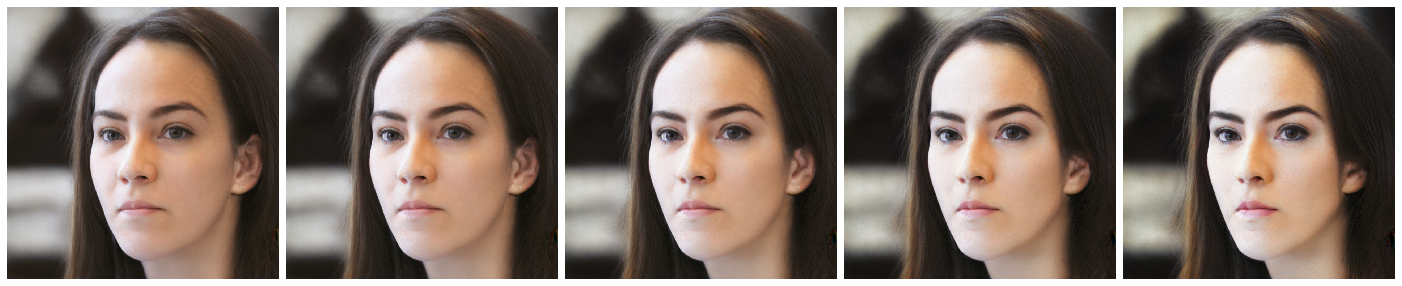

In [71]:
dlatent = load_dlatent(image_ids[0])
n = 5
shower = Shower(col=n)
plt.figure(figsize=(5 * n, 5))
for i in (0, 1, 2, 3, 4):
    w = i
    new_dlatent = dlatent + w * makeup_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

# hair color

In [163]:
color_map = {'brown': 0, 'gray': 1, 'blond': 2, 'black': 3, 'red': 4}
y_hair_color_dict = [x['faceAttributes']['hair']['hairColor'] for x in labels_data]
y_hair_color = []
x_for_hair = []

for i, sample in enumerate(y_hair_color_dict):
    tmp_res = [0] * 5
    maxx, maxx_color = 0, 'other'
    for arr_item in sample:
        color = arr_item['color']
        if color == 'other': continue
        if arr_item['confidence'] >= maxx:
            maxx, maxx_color = arr_item['confidence'], color
    if maxx_color != 'other':
        tmp_res[color_map[maxx_color]] = 1
        y_hair_color.append(tmp_res)
        x_for_hair.append(x_data[i])
y_hair_color = np.array(y_hair_color)
x_for_hair = np.array(x_for_hair)

In [158]:
def softmax(arr):
    arr_exp = np.exp(arr)
    arr_exp_sum = np.sum(arr_exp, axis=1, keepdims=True)
    return arr_exp / arr_exp_sum

In [182]:
# y_hair_color = softmax(y_hair_color)
len(y_hair_color)

18319

In [164]:
model = Sequential()
model.add(Dense(5, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)

In [165]:
model.fit(x_for_hair, y_hair_color, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 14655 samples, validate on 3664 samples
Epoch 1/100
14655/14655 [==============================] - 3s 239us/step - loss: 0.6896 - accuracy: 0.7299 - val_loss: 0.6266 - val_accuracy: 0.7399
Epoch 2/100
14655/14655 [==============================] - 2s 159us/step - loss: 0.6197 - accuracy: 0.7555 - val_loss: 0.6241 - val_accuracy: 0.7582
Epoch 3/100
14655/14655 [==============================] - 3s 178us/step - loss: 0.6126 - accuracy: 0.7625 - val_loss: 0.6491 - val_accuracy: 0.7492
Epoch 4/100
14655/14655 [==============================] - 3s 183us/step - loss: 0.5965 - accuracy: 0.7675 - val_loss: 0.6118 - val_accuracy: 0.7549
Epoch 5/100
14655/14655 [==============================] - 3s 177us/step - loss: 0.5917 - accuracy: 0.7700 - val_loss: 0.6849 - val_accuracy: 0.7484
Epoch 6/100
14655/14655 [==============================] - 3s 175us/step - loss: 0.5868 - accuracy: 0.7735 - val_loss: 0.6503 - val_accuracy: 0.7495
Epoch 7/100
14655/14655 [==============================] 

In [166]:
hair_direction = model.layers[0].get_weights()[0].reshape(18, 512, 5)
np.save('./data/hair_direction', hair_direction)

In [194]:
color_index = -2
certain_hair_direction = hair_direction[..., color_index]

In [195]:
certain_hair_direction.min(), certain_hair_direction.max()

(-0.17623396, 0.108092315)

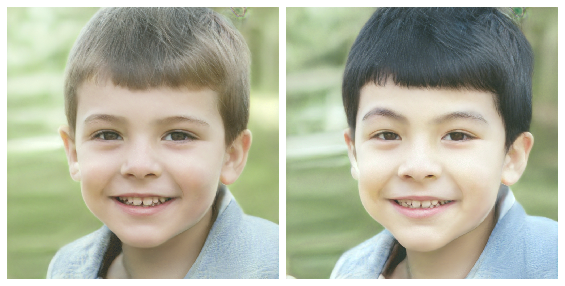

In [196]:
dlatent = load_dlatent(image_ids[1])
n = 5
shower = Shower(col=n)
plt.figure(figsize=(5 * n, 5))

for i in (0, 2):
    w = i
    new_dlatent = dlatent + w * certain_hair_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

# smile

In [197]:
y_smile = np.array([x['faceAttributes']['smile'] for x in labels_data])

In [199]:
model = Sequential()
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'mse', metrics=['mse'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
model.fit(x_data, y_smile, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 3s 174us/step - loss: 0.0743 - mse: 0.0743 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 2/100
16245/16245 [==============================] - 2s 147us/step - loss: 0.0602 - mse: 0.0602 - val_loss: 0.0593 - val_mse: 0.0593
Epoch 3/100
16245/16245 [==============================] - 3s 157us/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 4/100
16245/16245 [==============================] - 2s 152us/step - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0637 - val_mse: 0.0637
Epoch 5/100
16245/16245 [==============================] - 2s 136us/step - loss: 0.0571 - mse: 0.0571 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 6/100
16245/16245 [==============================] - 2s 141us/step - loss: 0.0565 - mse: 0.0565 - val_loss: 0.0655 - val_mse: 0.0655
Epoch 7/100
16245/16245 [==============================] - 3s 169us/step - loss: 0.0570 - mse: 0.0570 - val_loss: 0.0

In [200]:
smile_direction = model.layers[0].get_weights()[0].reshape(18, 512)
np.save('./data/smile_direction', smile_direction)

In [201]:
smile_direction.min(), smile_direction.max()

(-0.208477, 0.19175312)

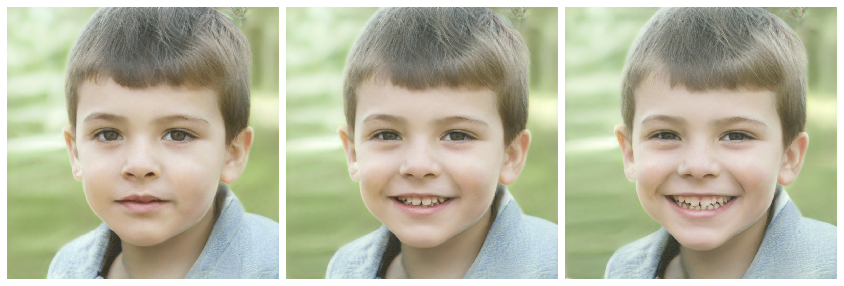

In [221]:
dlatent = load_dlatent(image_ids[1])
n = 5
shower = Shower(col=n)
plt.figure(figsize=(5 * n, 5))

for i in (-0.5, 0, 0.5):
    w = i
    new_dlatent = dlatent + w * smile_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

# emotion

In [206]:
emotion_map = {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutral': 5, 'sadness': 6, 'surprise': 7}
y_emotion_dict = [x['faceAttributes']['emotion'] for x in labels_data]
y_emotion = []
for i, sample in enumerate(y_emotion_dict):
    tmp_res = [0] * 8
    for typ, val in sample.items():
        tmp_res[emotion_map[typ]] = val
    y_emotion.append(tmp_res)

y_emotion = np.array(y_emotion)

In [207]:
y_emotion.sum(axis=1).sum(), len(y_emotion)

(20304.027000000002, 20307)

In [208]:
model = Sequential()
model.add(Dense(8, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)

In [209]:
model.fit(x_data, y_emotion, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 4s 220us/step - loss: 0.4960 - accuracy: 0.8435 - val_loss: 0.4616 - val_accuracy: 0.8641
Epoch 2/100
16245/16245 [==============================] - 3s 162us/step - loss: 0.4511 - accuracy: 0.8587 - val_loss: 0.4685 - val_accuracy: 0.8678
Epoch 3/100
16245/16245 [==============================] - 3s 181us/step - loss: 0.4441 - accuracy: 0.8643 - val_loss: 0.4890 - val_accuracy: 0.8592
Epoch 4/100
16245/16245 [==============================] - 3s 178us/step - loss: 0.4418 - accuracy: 0.8630 - val_loss: 0.4919 - val_accuracy: 0.8597
Epoch 5/100
16245/16245 [==============================] - 3s 194us/step - loss: 0.4438 - accuracy: 0.8620 - val_loss: 0.4941 - val_accuracy: 0.8511
Epoch 6/100
16245/16245 [==============================] - 3s 174us/step - loss: 0.4413 - accuracy: 0.8670 - val_loss: 0.4942 - val_accuracy: 0.8609
Epoch 7/100
16245/16245 [==============================] 

In [210]:
emotion_direction = model.layers[0].get_weights()[0]
emotion_direction = emotion_direction.reshape(18, 512, 8)
np.save('./data/emotion_direction', emotion_direction)

In [213]:
sadness_diretion = emotion_direction[..., 6]

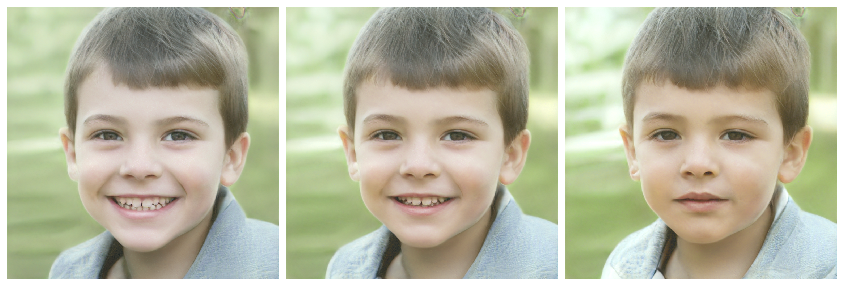

In [223]:
dlatent = load_dlatent(image_ids[1])
n = 3
shower = Shower(col=n)
plt.figure(figsize=(5 * n, 5))
for i in (-2, 0, 2):
    w = i
    new_dlatent = dlatent + w * sadness_diretion
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

# glasses

In [216]:
y_glasses = np.array([x['faceAttributes']['glasses'] != 'NoGlasses' for x in labels_data])
# {'NoGlasses', 'ReadingGlasses', 'Sunglasses', 'SwimmingGoggles'}

In [217]:
y_glasses.sum(), len(y_glasses)

(3911, 20307)

In [232]:
model = Sequential()
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)

model.fit(x_data, y_glasses, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 3s 207us/step - loss: 0.1733 - accuracy: 0.9307 - val_loss: 0.1538 - val_accuracy: 0.9404
Epoch 2/100
16245/16245 [==============================] - 3s 175us/step - loss: 0.1454 - accuracy: 0.9463 - val_loss: 0.1467 - val_accuracy: 0.9449
Epoch 3/100
16245/16245 [==============================] - 2s 142us/step - loss: 0.1413 - accuracy: 0.9480 - val_loss: 0.1458 - val_accuracy: 0.9419
Epoch 4/100
16245/16245 [==============================] - 3s 156us/step - loss: 0.1384 - accuracy: 0.9495 - val_loss: 0.1420 - val_accuracy: 0.9453
Epoch 5/100
16245/16245 [==============================] - 2s 154us/step - loss: 0.1373 - accuracy: 0.9508 - val_loss: 0.1387 - val_accuracy: 0.9461
Epoch 6/100
16245/16245 [==============================] - 3s 158us/step - loss: 0.1380 - accuracy: 0.9511 - val_loss: 0.1562 - val_accuracy: 0.9421
Epoch 7/100
16245/16245 [==============================] 

In [240]:
glasses_direction = model.layers[0].get_weights()[0]
glasses_direction = glasses_direction.reshape(18, 512)
np.save('./data/glasses_direction', glasses_direction)

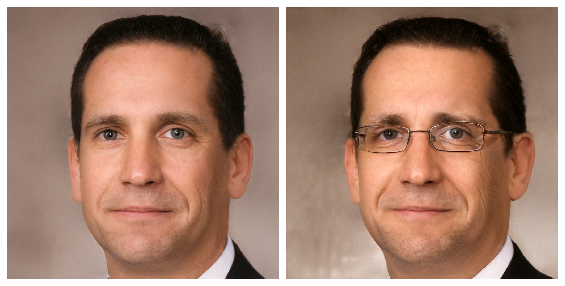

In [242]:
dlatent = load_dlatent(image_ids[2])
n = 5
shower = Shower(col=n)
plt.figure(figsize=(5 * n, 5))
for i in (0, 1.4):
    w = i
    new_dlatent = dlatent + w * glasses_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

In [243]:
############## foreheadOccluded
y_forehead_occlusion = np.array([x['faceAttributes']['occlusion']['foreheadOccluded'] for x in labels_data])
y_forehead_occlusion.sum(), len(y_forehead_occlusion)

(1528, 20307)

In [ ]:
clf = LogisticRegression(class_weight='balanced').fit(x_data, y_forehead_occlusion)
forehead_occlusion_direction = clf.coef_.reshape((18, 512))
np.save('./data/forehead_occlusion_direction', forehead_occlusion_direction)

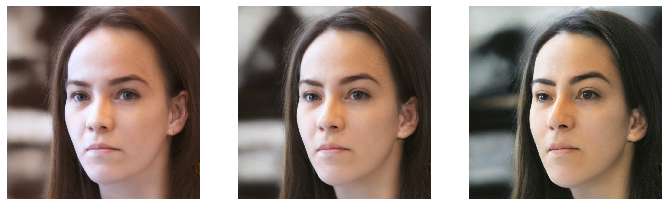

In [306]:
shower = Shower(col=5)
plt.figure(figsize=(20, 10))
for i in (-2, 0, 2):
    w = i
    new_dlatent = dlatent + w * forehead_occlusion_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

In [311]:
########## head_roll
y_head_roll = np.array([x['faceAttributes']['headPose']['roll'] for x in labels_data])
y_head_roll.min(), y_head_roll.max()

(-10.6, 9.6)

In [258]:
model = Sequential()
model.add(Dense(1, activation=None))
model.compile('adam', 'mse', metrics=['mse'])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)

model.fit(x_data, y_head_roll, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 3s 163us/step - loss: 1.8508 - mse: 1.8508 - val_loss: 1.8452 - val_mse: 1.8452
Epoch 2/100
16245/16245 [==============================] - 2s 141us/step - loss: 1.7678 - mse: 1.7678 - val_loss: 1.8196 - val_mse: 1.8196
Epoch 3/100
16245/16245 [==============================] - 2s 148us/step - loss: 1.7700 - mse: 1.7700 - val_loss: 1.8806 - val_mse: 1.8806
Epoch 4/100
16245/16245 [==============================] - 2s 152us/step - loss: 1.7590 - mse: 1.7590 - val_loss: 1.7299 - val_mse: 1.7299
Epoch 5/100
16245/16245 [==============================] - 2s 136us/step - loss: 1.7608 - mse: 1.7608 - val_loss: 1.8953 - val_mse: 1.8953
Epoch 6/100
16245/16245 [==============================] - 2s 145us/step - loss: 1.7550 - mse: 1.7550 - val_loss: 1.8870 - val_mse: 1.8870
Epoch 7/100
16245/16245 [==============================] - 2s 134us/step - loss: 1.7754 - mse: 1.7754 - val_loss: 1.8

In [255]:
head_roll_direction = model.layers[0].get_weights()[0].reshape(1, 18, 512)
np.save('./data/head_roll_direction', head_roll_direction)

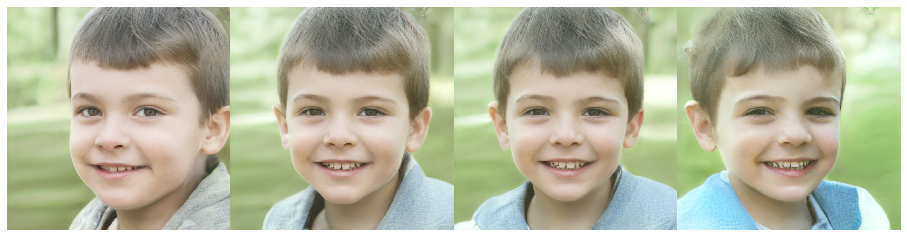

In [256]:
dlatent = load_dlatent(image_ids[1])
shower = Shower(col=5)
plt.figure(figsize=(20, 10))
for i in (5, 0, -3, -10):
    w = i
    new_dlatent = dlatent + w * head_roll_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

# head_yaw

In [269]:
y_head_yaw = np.array([x['faceAttributes']['headPose']['yaw'] for x in labels_data])
y_head_yaw.min(), y_head_yaw.max()

(-40.3, 39.0)

In [270]:
model = Sequential()
model.add(Dense(1, activation=None))
model.compile('adam', 'mse', metrics=['mse'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
model.fit(x_data, y_head_yaw, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 3s 183us/step - loss: 47.9130 - mse: 47.9130 - val_loss: 40.6109 - val_mse: 40.6109
Epoch 2/100
16245/16245 [==============================] - 2s 136us/step - loss: 37.7718 - mse: 37.7718 - val_loss: 39.3921 - val_mse: 39.3921
Epoch 3/100
16245/16245 [==============================] - 2s 143us/step - loss: 37.0638 - mse: 37.0638 - val_loss: 40.0444 - val_mse: 40.0444
Epoch 4/100
16245/16245 [==============================] - 3s 157us/step - loss: 36.8494 - mse: 36.8494 - val_loss: 39.0122 - val_mse: 39.0122
Epoch 5/100
16245/16245 [==============================] - 3s 180us/step - loss: 36.6825 - mse: 36.6825 - val_loss: 39.2053 - val_mse: 39.2053
Epoch 6/100
16245/16245 [==============================] - 3s 156us/step - loss: 36.4956 - mse: 36.4956 - val_loss: 39.1555 - val_mse: 39.1555
Epoch 7/100
16245/16245 [==============================] - 2s 145us/step - loss: 36.4322 - ms

In [272]:
head_yaw_direction = model.layers[0].get_weights()[0].reshape(1, 18, 512)
np.save('./data/head_yaw_direction', head_yaw_direction)

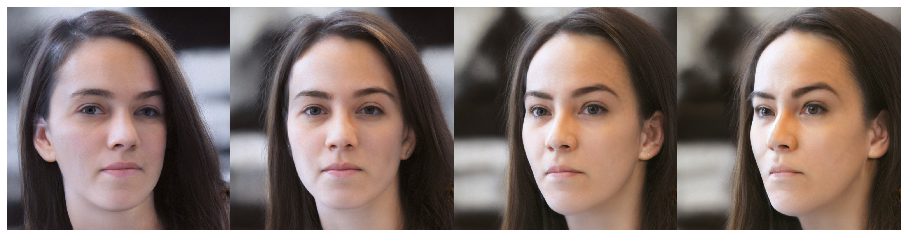

In [278]:
dlatent = load_dlatent(image_ids[0])
shower = Shower(col=5)
plt.figure(figsize=(20, 10))
for i in (2, 1, 0, -0.5):
    w = i
    new_dlatent = dlatent + w * head_yaw_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()

# facialHair

In [279]:
y_head_pitch = np.array([x['faceAttributes']['headPose']['pitch'] for x in labels_data])
y_head_pitch.min(), y_head_pitch.max()

(0.0, 0.0)

In [280]:
y_facialHair_dict = [x['faceAttributes']['facialHair'] for x in labels_data]
y_facialHair = np.array([(x['moustache'] + x['beard'] + x['sideburns']) / 3. for x in y_facialHair_dict])

In [281]:
model = Sequential()
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'mse', metrics=['mse'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
model.fit(x_data, y_facialHair, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 3s 212us/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 2/100
16245/16245 [==============================] - 3s 163us/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 3/100
16245/16245 [==============================] - 2s 144us/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 4/100
16245/16245 [==============================] - 2s 147us/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 5/100
16245/16245 [==============================] - 3s 167us/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 6/100
16245/16245 [==============================] - 2s 152us/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 7/100
16245/16245 [==============================] - 2s 137us/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0

In [282]:
facial_hair_direction = model.layers[0].get_weights()[0].reshape(18, 512)
facial_hair_direction.min(), facial_hair_direction.max()

(-0.09294534, 0.11344556)

In [284]:
np.save('./data/facial_hair_direction', facial_hair_direction)

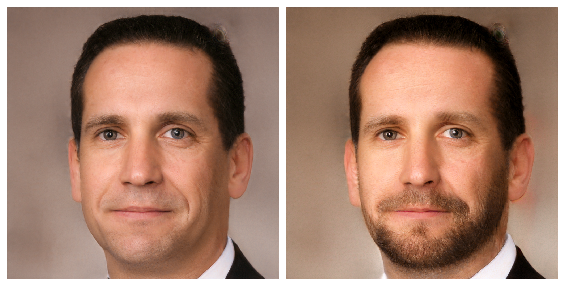

In [283]:
dlatent = load_dlatent(image_ids[2])
shower = Shower(col=2)
plt.figure(figsize=(10, 5))
for i in (0, 3):
    w = i
    new_dlatent = dlatent + w * facial_hair_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show('facial_hair')

# exposure

In [285]:
y_exposure = np.array([x['faceAttributes']['exposure']['value'] for x in labels_data])

In [286]:
model = Sequential()
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'mse', metrics=['mse'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
model.fit(x_data, y_exposure, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Train on 16245 samples, validate on 4062 samples
Epoch 1/100
16245/16245 [==============================] - 3s 193us/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 2/100
16245/16245 [==============================] - 2s 144us/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 3/100
16245/16245 [==============================] - 3s 155us/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 4/100
16245/16245 [==============================] - 2s 153us/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 5/100
16245/16245 [==============================] - 2s 151us/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 6/100
16245/16245 [==============================] - 2s 152us/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 7/100
16245/16245 [==============================] - 3s 155us/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0

In [289]:
exposure_direction = model.layers[0].get_weights()[0].reshape(18, 512)
np.save('./data/exposure_direction', exposure_direction)

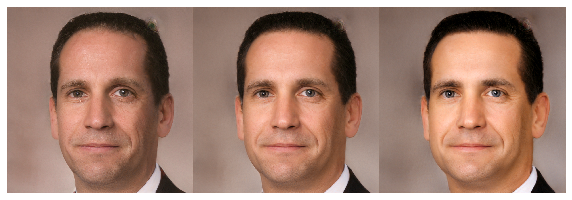

In [291]:
dlatent = load_dlatent(image_ids[2])
shower = Shower(col=3)
plt.figure(figsize=(10, 5))
for i in (-8, 0, 8):
    w = i
    new_dlatent = dlatent + w * exposure_direction
    new_image = generator.generate_images(new_dlatent)[0]
    shower.add(new_image)
shower.show()